In [1]:
%pip install requests==2.32.3
%pip install pandas==2.2.3
%pip install numpy==2.2.5
%pip install matplotlib==3.10.1
%pip install scikit-learn==1.6.1
%pip install dbrepo==1.7.3

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.6 MB 14.1 MB/s eta 0:00:01
   ---------------- ----------------------- 5.2/12.6 MB 13.4 MB/s eta 0:00:01
   --------------------------- ------------ 8.7/12.6 MB 14.6 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.6 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, which is not installed.
seaborn 0.13.2 requires matplotlib!=3.6.1,>=3.4, which is not installed.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl (8.1 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl (11.1 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached dbrepo-1.7.3-py3-none-any.whl.metadata (17 kB)
Using cached dbrepo-1.7.3-py3-none-any.whl (31 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pickle
from datetime import datetime
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dbrepo.RestClient import RestClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error, r2_score,)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [3]:
client = RestClient(endpoint="https://test.dbrepo.tuwien.ac.at", username="12006729", password="Arschbacke11!")

df_train = client.get_identifier_data(identifier_id="2401ab5e-693b-4235-b14e-0f3eb53ec773")
df_test = client.get_identifier_data(identifier_id="723c26fe-f89d-475c-a69e-83336b32c7bf")
df_valid = client.get_identifier_data(identifier_id="1e5040fc-8d05-4480-8176-975ad338f4d3")

for df in (df_train, df_test, df_valid):
    df['pieces'] = df['pieces'].astype(float).astype(int)
    df['age'] = df['age'].astype(float).astype(int)
    df['msrp_int'] = df['msrp_int'].astype(float).astype(int)
    df['price_int'] = df['price_int'].astype(float).astype(int)
    df['id'] = df['id'].astype(float).astype(int)

cat_cols = ['theme','theme_group','subtheme']
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

enc.fit(df_train[cat_cols])

for split in (df_train, df_test, df_valid):
    split[cat_cols] = enc.transform(split[cat_cols]).astype(int)

features = ['theme','theme_group','subtheme','age','pieces','msrp_int']
X_train, y_train = df_train[features], df_train['price_int']
X_test,  y_test  = df_test [features], df_test ['price_int']
X_valid,   y_valid   = df_valid[features], df_valid['price_int']

model = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=12006729))
])

model.fit(X_train, y_train)

y_pred_val = model.predict(X_valid)
print("VALIDATION")
print(" MAE:  ", mean_absolute_error(y_valid, y_pred_val))
print(" RMSE: ", mean_squared_error(y_valid, y_pred_val))
print(" R²:   ", r2_score(y_valid, y_pred_val))

y_pred_test = model.predict(X_test)
print("\nTEST")
print(" MAE:  ", mean_absolute_error(y_test, y_pred_test))
print(" RMSE: ", mean_squared_error(y_test, y_pred_test))
print(" R²:   ", r2_score(y_test, y_pred_test))



VALIDATION
 MAE:   9.74234492485976
 RMSE:  174.39390793357848
 R²:    0.6928987234861599

TEST
 MAE:   9.702200260178662
 RMSE:  168.99610472916962
 R²:    0.674333702360699


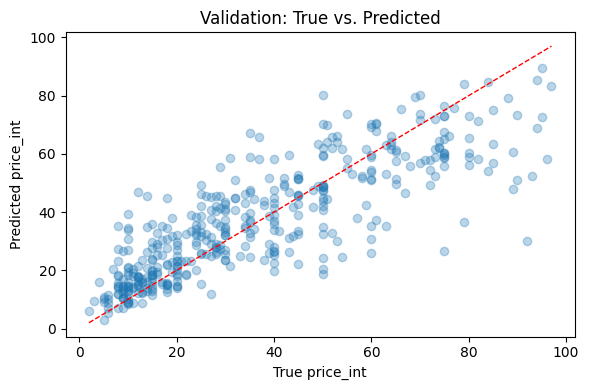

In [4]:
model_path = "rf_price_predictor.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)


plt.figure(figsize=(6,4))
plt.scatter(y_valid, y_pred_val, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         'r--', linewidth=1)
plt.xlabel("True price_int")
plt.ylabel("Predicted price_int")
plt.title("Validation: True vs. Predicted")
plt.tight_layout()

plot_path = "val_true_vs_pred.png"
plt.savefig(plot_path, dpi=150)




In [ ]:
# Automatic upload -- not working


# access_token = 'tUxjl9cFYEzhdiMNoC1t9Wp8FBb7m3WHfVcUqBY9PkivqSlMgtLw4X9q1fl4'
# url = "https://test.researchdata.tuwien.at/api/records"

# today = datetime.now().date().isoformat()


# headers = {
#     "Authorization": f"Bearer {access_token}",
#     "Content-Type": "application/json"
# }
# data = {
#     "metadata": {
#         "creators": [
#             {
#                 "person_or_org": {
#                     "family_name": "Waser",
#                     "given_name": "Konstantin",
#                     "type": "personal",
#                 }
#             }
#         ],
#         "publication_date": today,
#         "publisher": "TU Wien",
#         "resource_type": {"id": "dataset"},
#         "title": "LEGO_Dataset",
#     },
#     "files": {"enabled": True},
# }

# response = requests.post(url, json=data, headers=headers)
# print(response.json())

{'status': 403, 'message': 'Permission denied.'}
